# 2.2 Dataset 구현, 2.3 DataLoader 구현

이 파일에서는 SSD 등 물체 검출 알고리즘용 Dataset과 DataLoader를 작성합니다.

VOC2012 데이터 세트를 대상으로 합니다.

# 2.2 학습 목표

1. 물체 검출에 사용하는 Dataset 클래스를 작성할 수 있게 된다
2. SSD 학습 시의 데이터 인증으로 무엇을 하고 있는지 이해

# 2.3 학습 목표

1. 물체 검출에 사용하는 DataLoader 클래스를 작성할 수 있게 된다

# 사전 준비


OpenCV 설치

- pip install opencv-python

이 설명서의 지침에 따라 VOC2010 데이터 세트 다운로드

- http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

In [1]:
# 패키지 import
import os.path as osp
import random
# XML을 파일이나 텍스트에서 읽고, 가공하고, 저장하는 라이브러리
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [2]:
# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 이미지 데이터, 주석 데이터에 대한 파일 경로 목록 만들기

In [13]:
# 학습, 검증 이미지 및 주석 데이터에 대한 파일 경로 목록 만들기

def make_datapath_list(rootpath):
    """
    데이터에 대한 경로를 포함하는 목록을 만듭니다.

    Parameters
    ----------
    rootpath : str
     데이터 폴더 경로

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
     데이터 경로를 포함한 목록
    """

    # 이미지 및 주석 파일에 대한 경로 템플릿 만들기
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 학습 및 검증, 각 파일의 ID(파일 이름)를 얻습니다.
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 학습 데이터 이미지 및 주석 파일에 대한 경로 목록 만들기
    train_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()  # 빈 공간과 줄 바꿈을 제거
        img_path = (imgpath_template % file_id)  # 이미지 경로
        anno_path = (annopath_template % file_id)  # 주석 경로
        train_img_list.append(img_path)  # 목록에 추가
        train_anno_list.append(anno_path)  # 목록에 추가
        
    # 검증 데이터의 이미지 파일과 주석 파일에 대한 경로 목록 만들기
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 빈 공간과 줄 바꿈을 제거
        img_path = (imgpath_template % file_id)  # 이미지 경로
        anno_path = (annopath_template % file_id)  # 주석 경로
        val_img_list.append(img_path)  # 목록에 추가
        val_anno_list.append(anno_path)  # 목록에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [14]:
# ファイルパスのリストを作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# 動作確認
print(train_img_list[0])


./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


# xml 형식의 주석 데이터를 목록으로 변환

In [21]:
# "XML 형식의 주석"을 목록 형식으로 변환하는 클래스

class Anno_xml2list(object):
    """
    1장의 화상에 대한 「XML 형식의 어노테이션 데이터」를, 화상 사이즈로 규격화하고 나서 리스트 형식으로 변환한다.

    Attributes
    ----------
    classes : 목록
     VOC 클래스 이름을 포함하는 목록
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        1장의 화상에 대한 「XML 형식의 어노테이션 데이터」를, 화상 사이즈로 규격화하고 나서 리스트 형식으로 변환한다.

        Parameters
        ----------
        xml_path : str
         xml 파일의 경로.
        width : int
         대상 이미지의 폭.
        height : int
         대상 이미지의 높이.

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
         객체의 annotation 데이터를 저장하는 목록. 이미지 내에 존재하는 물체 수만큼의 요소만을 갖는다.
        """

        # 이미지의 모든 객체에 대한 annotation이 목록에 저장합니다.
        ret = []

        # xml 파일 로드
        xml = ET.parse(xml_path).getroot()

        # 이미지에 있는 물체(object)의 수만큼 루프한다
        for obj in xml.iter('object'):

            # 어노테이션에서 감지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 하나의 객체에 대한 주석을 저장하는 목록
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 물체명
            bbox = obj.find('bndbox')  # bbox 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득해, 0~1로 규격화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC는 원점이 (1,1)이므로 1을 뺀 (0, 0)
                cur_pixel = int(bbox.find(pt).text) - 1
                
                # 폭, 높이로 표준화
                if pt == 'xmin' or pt == 'xmax':  # x 방향일 때는 폭으로 나누기
                    cur_pixel /= width
                else:  # y 방향일 때는 높이로 나누기
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션의 클래스 이름 index를 가져오고 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # ret에 [xmin, ymin, xmax, ymax, label_ind]를 더한다
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

In [50]:
# 動作確認　
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 이미지 로드 OpenCV 사용
ind = 1
image_file_path = val_img_list[ind]
print(val_img_list[ind])

img = cv2.imread(image_file_path)  # [높이] [너비] [색 BGR]

height, width, channels = img.shape  # 이미지 크기 얻기

# 어노테이션을 목록으로 표시
print(val_anno_list[ind])
transform_anno(val_anno_list[ind], width, height)

./data/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg
./data/VOCdevkit/VOC2012/Annotations/2008_000003.xml


array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

# 이미지와 주석을 전처리하는 클래스 DataTransform 만들기

In [25]:
# 폴더 "utils"에있는 data_augumentation.py에서 import.
# 입력 이미지를 전처리하는 클래스
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    
    """
    이미지 및 어노테이션의 전처리 클래스. 훈련과 추론으로 다른 동작을 한다.
    이미지 크기를 300x300으로 설정합니다.
    학습시는 데이터 Augmentation한다.


    Attributes
    ----------
    input_size : int
     크기 조정 대상 이미지의 크기.
    color_mean : (B, G, R)
     각 색상 채널의 평균값.
    """
    
    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # int를 float32로 변환
                ToAbsoluteCoords(),  # 어노테이션 데이터의 규격화 반환
                PhotometricDistort(),  # 이미지의 색조 등 임의로 변화
                Expand(color_mean),  # 이미지의 확대
                RandomSampleCrop(),  # 이미지의 일부를 무작위로 추출
                RandomMirror(),  # 이미지 반전
                ToPercentCoords(),  # annotation 데이터를 0-1로 표준화
                Resize(input_size),  # 이미지 크기를 input_size×input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상의 평균값을 뺀
            ]),
            'val': Compose([
                ConvertFromInts(),  # int를 float32로 변환
                Resize(input_size),  # 이미지 크기를 input_size×input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상의 평균값을 뺀
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
         전처리 모드를 지정.
        """
        return self.data_transform[phase](img, boxes, labels)


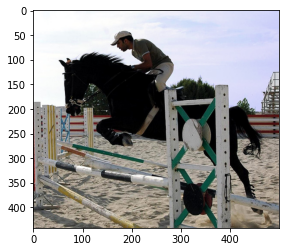

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


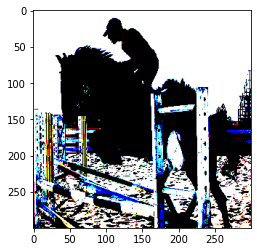

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


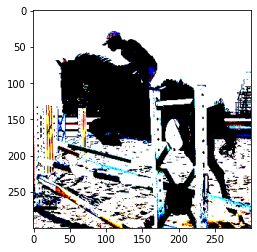

In [31]:
# 동작 확인

# 1. 이미지 로드
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path) # [높이][너비][색 BGR]
height, width, channels = img.shape # 이미지 크기 가져오기

# 2. 어노테이션을 목록으로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원본 이미지 표시
plt.imshow (cv2.cvtColor (img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스 만들기
color_mean = (104, 117, 123) # (BGR)의 색상 평균
input_size = 300 # 이미지의 input 크기를 300×300으로 설정
transform = DataTransform(input_size, color_mean)

# 5. train 이미지 표시
phase="train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow (cv2.cvtColor (img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val 이미지 표시
phase="val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow (cv2.cvtColor (img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# Dataset 만들기

In [38]:
# VOC2012 Dataset 만들기


class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 작성하는 클래스. PyTorch의 Dataset 클래스를 상속.

    Attributes
    ----------
    img_list : 목록
        이미지 경로가 포함된 목록
    anno_list : 목록
        어노테이션에 대한 경로가 포함된 목록
    phase : 'train' or 'test'
        학습인지 훈련인지를 설정합니다.
    transform : object
        전처리 클래스의 인스턴스
    transform_anno : object
        xml의 ​​주석을 목록으로 변환하는 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list=img_list
        self.anno_list = anno_list
        self.phase = phase # train 또는 val을 지정
        self.transform = transform # 이미지 변형
        self.transform_anno = transform_anno # 어노테이션 데이터를 xml에서 목록으로

    def __len__(self):
        '''이미지 매수 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리 된 이미지의 텐서 형식 데이터 및 주석 획득
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''전처리 된 이미지의 텐서 형식 데이터, 주석, 이미지 높이 및 너비 가져 오기 '''

        # 1. 이미지 로드
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path) # [높이][너비][색 BGR]
        height, width, channels = img.shape # 이미지 크기 가져오기

        # 2. xml 형식의 주석 정보를 목록에
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 컬러 채널의 순서가 BGR이므로 RGB로 순서 변경
        # 또한 (높이, 너비, 색상 채널) 순서를 (색상 채널, 높이, 너비)로 변환
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBox와 라벨을 세트로 한 np.array를 작성, 변수명 「gt」는ground truth(답)의 약칭
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [39]:
# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# データの取り出し例
val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

# DataLoader 만들기

In [45]:
def od_collate_fn(batch):
    """
    Dataset에서 검색하는 annotation 데이터의 크기는 이미지마다 다릅니다.
    화상내의 물체수가 2개이면(2, 5)라고 하는 사이즈입니다만, 3개이면(3, 5)등 변화합니다.
    이 변화에 대응하는 DataLoader를 작성하기 위해,
    커스터마이즈 된 collate_fn을 만듭니다.
    collate_fn은 PyTorch에서 목록에서 mini-batch를 만드는 함수입니다.
    미니 배치분의 이미지가 나란히 있는 리스트 변수 batch에,
    미니 배치 번호를 지정하는 차원을 앞에 하나 추가하여 목록의 모양을 변형합니다.
    """

    targets=[]
    imgs=[]
    for sample in batch:
        imgs.append(sample[0]) # sample[0] 은 이미지 img입니다.
        targets.append(torch.FloatTensor(sample[1])) # sample[1] 은 주석 gt입니다.

    #imgs는 미니 배치 크기 목록입니다.
    # 목록의 요소는 torch.Size([3, 300, 300])입니다.
    #이 목록을 torch.Size ([batch_num, 3, 300, 300])의 텐서로 변환합니다.
    imgs = torch.stack(imgs, dim=0)
    
    # targets는 주석 데이터의 정답인 gt의 목록입니다.
    # 목록의 크기는 미니 배치 크기입니다.
    # 목록 targets의 요소는 [n, 5]입니다.
    # n은 이미지마다 다르며 이미지에 있는 객체의 수입니다.
    # 5는 [xmin, ymin, xmax, ymax, class_index]입니다.

    return imgs, targets

In [47]:
# 데이터 로더 만들기

batch_size=4

train_dataloader = data.DataLoader(
     train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
     val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전형 변수로 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"]) # 이터레이터로 변환
images, targets = next(batch_iterator) # 첫 번째 요소 검색
print(images.size()) # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size()) # 미니 배치의 크기의 리스트, 각 요소는 [n, 5], n은 물체수

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [48]:
print(train_dataset.__len__())
print(val_dataset.__len__())


5717
5823


以上